# Youtube Comments Spam Classification

In this project, the dataset of youtube comments spam is retrieved from UCI's Machine Learning Repository. A spam detection model is selected by using two machine learning classifer (Random Forest classifier and Gradient Boosting Classifier) to predict whether the Youtube Comments is spam or not. 

#### Required Python Library

In [1]:
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string

#### Data Preparation

In [2]:
data = pd.concat(map(pd.read_csv, ['Youtube01-Psy.csv', 'Youtube02-KatyPerry.csv', 'Youtube03-LMFAO.csv', 'Youtube04-Eminem.csv', 'Youtube05-Shakira.csv']))
data.columns = ['comment_id', 'author', 'date', 'content', 'class']

#### Adding Body Length and Punctuation % to the dataset

In [3]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['body_len'] = data['content'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['content'].apply(lambda x: count_punct(x))

#### Evaluate New Feature Body Length

In [4]:
from matplotlib import pyplot
import numpy as np
%matplotlib inline

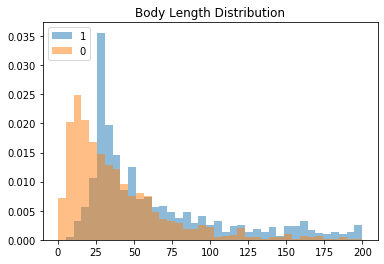

In [5]:
bins = np.linspace(0, 200, 40)

pyplot.hist(data[data['class']==1]['body_len'], bins, alpha=0.5, density=True, label=1)
pyplot.hist(data[data['class']==0]['body_len'], bins, alpha=0.5, density=True, label=0)
pyplot.legend(loc='upper left')
pyplot.title("Body Length Distribution")
pyplot.show()

#### Evaluate New Feature Punctuation %

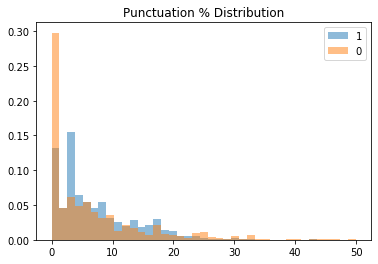

In [6]:
bins = np.linspace(0, 50, 40)

pyplot.hist(data[data['class']==1]['punct%'], bins, alpha=0.5, density=True, label=1)
pyplot.hist(data[data['class']==0]['punct%'], bins, alpha=0.5, density=True, label=0)
pyplot.legend(loc='upper right')
pyplot.title("Punctuation % Distribution")
pyplot.show()

Since the dataset is skewed to the right, box-cox transformation is performed

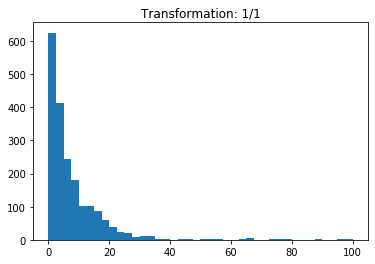

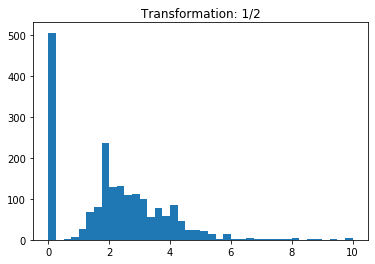

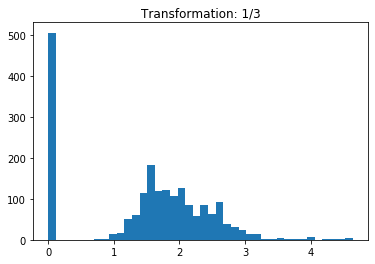

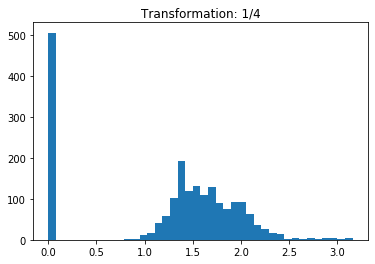

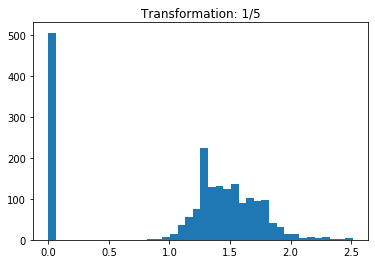

In [7]:
for i in [1, 2, 3, 4, 5]:
    pyplot.hist((data['punct%'])**(1/i), bins=40)
    pyplot.title("Transformation: 1/{}".format(str(i)))
    pyplot.show()

From the above box-cox tranformation, transformation with 1/4 gives the most proper normal shape to the dataset.

In [8]:
data['punct%'] = data['punct%']**1/4

#### Function for cleaning text

In [9]:
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

#### Random Forest Grid Search with 5-fold Cross-Validation

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(data['content'])
X_tfidf_feat = pd.concat([data[['body_len', 'punct%']].reset_index(drop=True), pd.DataFrame(X_tfidf.toarray())], axis=1)

In [11]:
rf = RandomForestClassifier()
param = {'n_estimators': [10, 150, 300],
        'max_depth': [30, 60, 90, None]}

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1)
gs_fit = gs.fit(X_tfidf_feat, data['class'])
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,9.955398,0.780649,0.128491,0.024949,None,300,"{'max_depth': None, 'n_estimators': 300}",0.844388,0.920716,0.943734,0.966752,0.956522,0.926422,0.043805,1
10,5.947987,0.111030,0.098537,0.012485,None,150,"{'max_depth': None, 'n_estimators': 150}",0.849490,0.915601,0.943734,0.971867,0.948849,0.925908,0.042195,2
8,10.386766,0.582278,0.152347,0.013050,90,300,"{'max_depth': 90, 'n_estimators': 300}",0.836735,0.925831,0.930946,0.964194,0.948849,0.921311,0.044416,3
7,5.361805,0.199419,0.088691,0.007444,90,150,"{'max_depth': 90, 'n_estimators': 150}",0.823980,0.913043,0.938619,0.964194,0.946292,0.917226,0.049439,4
5,9.150255,0.300385,0.146224,0.014313,60,300,"{'max_depth': 60, 'n_estimators': 300}",0.813776,0.900256,0.941176,0.961637,0.948849,0.913139,0.053763,5


#### Gradient Boosting Grid Search with 5-fold Cross-Validation

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
param = {
    'n_estimators': [100, 150], 
    'max_depth': [7, 11, 15],
    'learning_rate': [0.1]
}

clf = GridSearchCV(gb, param, cv=5, n_jobs=-1)
cv_fit = clf.fit(X_tfidf_feat, data['class'])
pd.DataFrame(cv_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,72.940055,2.379552,0.051844,0.000851,0.1,11,150,"{'learning_rate': 0.1, 'max_depth': 11, 'n_est...",0.829082,0.895141,0.928389,0.974425,0.953964,0.916200,0.050986,1
0,33.355932,1.238924,0.055633,0.013190,0.1,7,100,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.818878,0.905371,0.930946,0.976982,0.946292,0.915694,0.053675,2
1,51.364109,1.366572,0.046723,0.003078,0.1,7,150,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.821429,0.895141,0.930946,0.974425,0.948849,0.914158,0.053062,3
4,51.154784,3.168459,0.060738,0.023974,0.1,15,100,"{'learning_rate': 0.1, 'max_depth': 15, 'n_est...",0.808673,0.895141,0.930946,0.971867,0.948849,0.911095,0.057022,4
2,46.075111,1.340372,0.046458,0.004031,0.1,11,100,"{'learning_rate': 0.1, 'max_depth': 11, 'n_est...",0.811224,0.897698,0.925831,0.974425,0.946292,0.911094,0.055893,5


#### Training and Testing Data

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['content', 'body_len', 'punct%']], data['class'], test_size=0.2)

In [14]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['content'])

tfidf_train = tfidf_vect_fit.transform(X_train['content'])
tfidf_test = tfidf_vect_fit.transform(X_test['content'])

X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,3200,3201,3202,3203,3204,3205,3206,3207,3208,3209
0,27,1.850,0.148967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,57,2.200,0.109702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96,3.125,0.076657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.000,0.206463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,81,3.700,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import time

In [16]:
rf = RandomForestClassifier(n_estimators=300, max_depth=None, n_jobs=-1)

start = time.time()
rf_model = rf.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = rf_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=1, average='binary')
print('Fit time: {} \nPredict time: {} \nPrecision: {} \nRecall: {} \nAccuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 2.828 
Predict time: 0.156 
Precision: 0.927 
Recall: 0.946 
Accuracy: 0.934


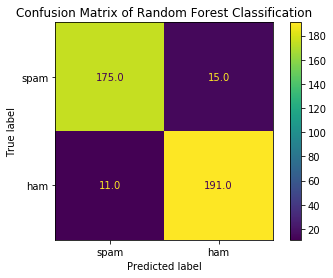

In [17]:
from sklearn.metrics import plot_confusion_matrix

confusion_matrix = plot_confusion_matrix(rf, X_test_vect, y_test, display_labels=["spam", "ham"], values_format=".1f")
pyplot.title('Confusion Matrix of Random Forest Classification')
pyplot.show()

In [18]:
gb = GradientBoostingClassifier(n_estimators=150, max_depth=11)

start = time.time()
gb_model = gb.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = gb_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=1, average='binary')
print('Fit time: {} \nPredict time: {} \nPrecision: {} \nRecall: {} \nAccuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 46.199 
Predict time: 0.024 
Precision: 0.958 
Recall: 0.911 
Accuracy: 0.934


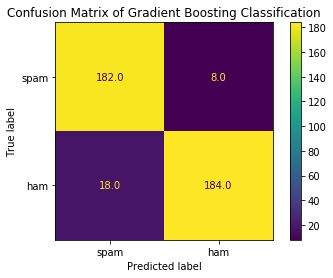

In [19]:
confusion_matrix = plot_confusion_matrix(gb, X_test_vect, y_test, display_labels=["spam", "ham"], values_format=".1f")
pyplot.title('Confusion Matrix of Gradient Boosting Classification')
pyplot.show()

#### Conclusion

Random Forest Classification's performance and Gradient Boosting Classification's performace both share a similar rate for precision, recall and accuracy.
However, the fitting time for Random Forest Classification is faster than Gradient Boosting Classification because Random Forest trains the dataset in parallel. On the other hand, Gradient Boosting trains the dataset iteratively based on the prior iteration by adding weight until the error is minimized.
Overall, the models selected using Random Forest Classification and Gradient Boosting Classification provide a similar prediction in terms of spam detection for the youtube comments.
Since a spam filter for youtube comments should not filter out the real comments, precision rate is prioritized in this situation, the chosen Gradient Boosting Classification model is a better fit for this project.